In [390]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

from genrisk.shift import ConditionalShift
from genrisk.generation import LSTMVAE, TCNVAE

In [74]:
url = 'https://raw.githubusercontent.com/unit8co/darts/master/datasets/ETTh1.csv'
r = requests.get(url)
with open('ETTh1.csv', 'wb') as f:
    f.write(r.content)
target = pd.read_csv('ETTh1.csv', index_col=0)['OT']
target.name = 'target'
target.index = pd.to_datetime(target.index)
target.index.name = 'date'
target = ts_data.asfreq('D')
target

date
2016-07-01    30.531000
2016-07-02    21.104000
2016-07-03    29.334999
2016-07-04    21.667000
2016-07-05    25.958000
                ...    
2018-06-22     8.231000
2018-06-23     5.346000
2018-06-24     6.894000
2018-06-25     8.723000
2018-06-26     9.708000
Freq: D, Name: target, Length: 726, dtype: float64

In [75]:
exog = pd.get_dummies(ts_data.index.day_of_week, prefix='d', dtype=int)
exog.index = ts_data.index
exog

,d_0,d_1,d_2,d_3,d_4,d_5,d_6
date,,,,,,,
2016-07-01,0,0,0,0,1,0,0
2016-07-02,0,0,0,0,0,1,0
2016-07-03,0,0,0,0,0,0,1
2016-07-04,1,0,0,0,0,0,0
2016-07-05,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
2018-06-22,0,0,0,0,1,0,0
2018-06-23,0,0,0,0,0,1,0
2018-06-24,0,0,0,0,0,0,1


In [76]:
horizon = 7
input_size = 28

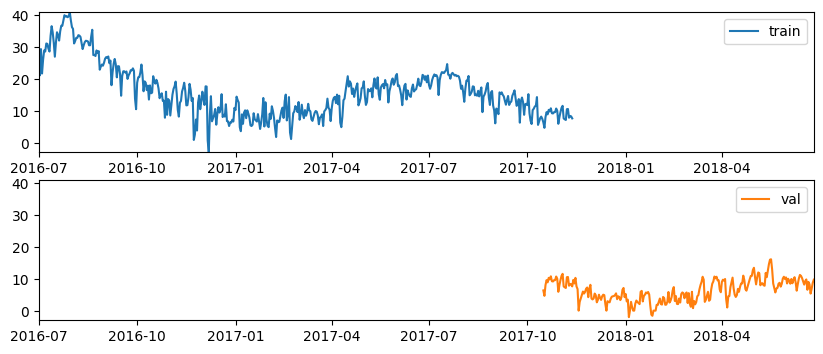

In [493]:
split = 500
target_train = target[:split]
target_val = target[split-input_size:]
exog_train = exog[:split]
exog_val = exog[split-input_size:]

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(target_train, label='train')
plt.xlim(ts_data.index[0], ts_data.index[-1])
plt.ylim(ts_data.min(), ts_data.max())
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(target_val, label='val', c='tab:orange')
plt.xlim(ts_data.index[0], ts_data.index[-1])
plt.ylim(ts_data.min(), ts_data.max())
plt.legend()
plt.show()

In [494]:
class SARIMA():
    def __init__(self, p, i, q, P, I, Q, s):
        self.p = p
        self.i = i
        self.q = q
        self.P = P
        self.I = I
        self.Q = Q
        self.s = s
    def fit(self, target, exog=None):
        model = SARIMAX(
            target, exog, 
            order=(self.p, self.i, self.q),
            seasonal_order=(self.P, self.I, self.Q, self.s),
        )
        self.res = model.fit(disp=False, maxiter=500)
    def predict(self, horizon, past_target, past_exog=None, future_exog=None):
        res = self.res.apply(endog=past_target, exog=past_exog)
        pred = res.forecast(steps=horizon, exog=future_exog)
        return pred
    def backtest(self, input_size, horizon, target, exog):
        abs_error = []
        for i in range(len(target)-input_size-horizon+1):
            past_range = range(i, i+input_size)
            future_range = range(i+input_size, i+input_size+horizon)
            past_target = target.iloc[past_range]
            future_target = target.iloc[future_range]
            past_exog = exog.iloc[past_range]
            future_exog = exog.iloc[future_range]
            future_pred = self.predict(horizon, past_target, past_exog, future_exog)
            abs_error.append(np.abs(future_pred - future_target))
        return pd.Series(np.array(abs_error).mean(axis=1), index=target.index[input_size+horizon-1:])

In [495]:
model = SARIMA(p=1, i=1, q=0, P=1, I=1, Q=0, s=7)
model.fit(
    target_train, 
    exog_train,
)

In [496]:
error_val = model.backtest(input_size, horizon, target_val, exog_val)
error_val.mean()

2.963395244684837

In [497]:
X_val = pd.DataFrame(target_val)
for i in range(1, input_size):
    X_val[f'target_{i}'] = X_val['target'].shift(i)
X_val = pd.concat([X_val, exog_val], axis=1).dropna()
X_val = X_val[:-horizon]
X_val.shape

(220, 35)

In [498]:
mutable_columns = X_val.columns[:input_size].tolist()
immutable_columns = X_val.columns[input_size:].tolist()

In [499]:
alpha_space = np.linspace(0.05, 0.95, 10)
alpha_space

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [486]:
risk_val = []
for alpha in tqdm(alpha_space):
    shift_model = ConditionalShift(mutable_columns, immutable_columns, alpha=alpha, cv=5)
    shift_model.fit(X_val, error_val)
    risk_val.append([shift_model.risk, shift_model.lb_risk, shift_model.ub_risk])
risk_val = np.array(risk_val)

  0%|          | 0/10 [00:00<?, ?it/s]

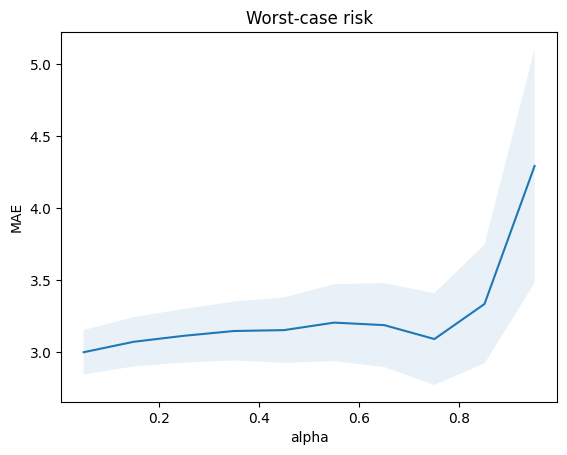

In [487]:
plt.plot(alpha_space, risk_val[:, 0])
plt.fill_between(alpha_space, risk_val[:, 1], risk_val[:, 2], alpha=0.1)
plt.title('Worst-case risk')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.show()

In [488]:
scaler = StandardScaler()
target_exog_val = pd.concat([target_val, exog_val], axis=1)
target_exog_val.target = scaler.fit_transform(target_exog_val[['target']])

In [501]:
gen = TCNVAE(
    target_columns=['target'], 
    conditional_columns=immutable_columns,
    window_size=100,
    latent_dim=1,
    hidden_dim=64,
    num_layers=4,
    num_epochs=200,
    batch_size=64,
    lr=0.0001,
    verbose=True,
)
gen.fit(target_exog_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type        | Params
-------------------------------------
0 | enc  | _TCNEncoder | 88.8 K
1 | dec  | _TCNDecoder | 88.7 K
-------------------------------------
177 K     Trainable params
0         Non-trainable params
177 K     Total params
0.710     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


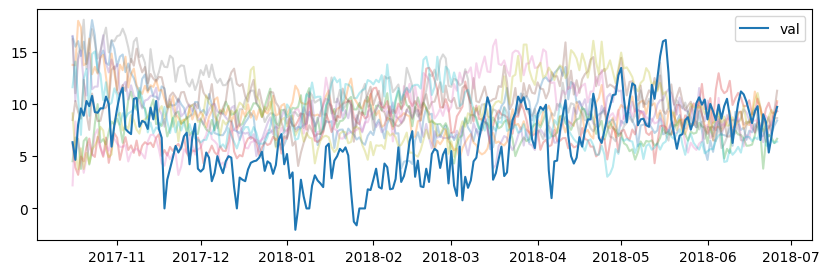

In [502]:
plt.figure(figsize=(10, 3))
fakes = []
for fake in gen.sample(exog_val, n_samples=10):
    fake.target = scaler.inverse_transform(fake[['target']])
    plt.plot(fake.target, alpha=0.3)
    fakes.append(fake)
plt.plot(target_val, label='val', c='tab:blue')
plt.legend();

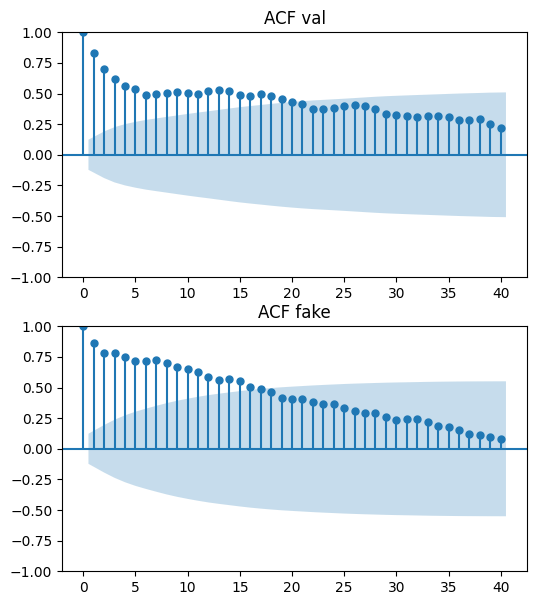

In [503]:
fakes = pd.concat(fakes)
plt.figure(figsize=(6, 7))
ax = plt.subplot(2, 1, 1)
plot_acf(target_val, lags=40, title='ACF val', ax=ax)
ax = plt.subplot(2, 1, 2)
plot_acf(fake.target, lags=40, title='ACF fake', ax=ax);

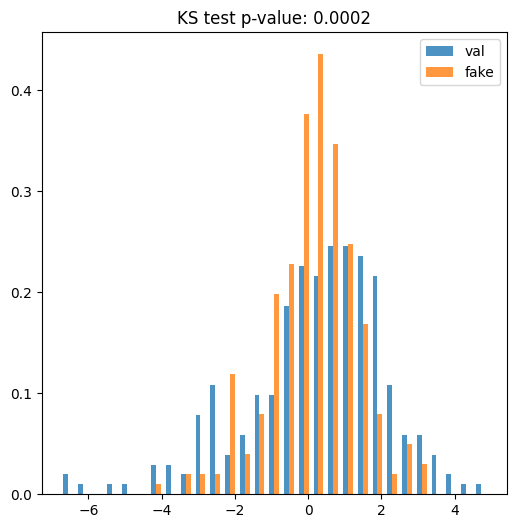

In [504]:
target_val_diff = target_val - target_val.shift(1)
target_val_diff = target_val_diff.dropna()
target_fake_diff = fake.target - fake.target.shift(1)
target_fake_diff = target_fake_diff.dropna()

plt.figure(figsize=(6, 6))
bins = np.linspace(target_val_diff.min(), target_val_diff.max(), 30)
width = (bins[1] - bins[0]) / 3
sep = width / 2
hist, _ = np.histogram(target_val_diff, bins=bins, density=True)
plt.bar(bins[1:]-sep, hist, width=width, label='val', alpha=0.8)
hist, _ = np.histogram(target_fake_diff, bins=bins, density=True)
plt.bar(bins[1:]+sep, hist, width=width, label='fake', alpha=0.8)
plt.legend()
plt.title(f'KS test p-value: {ks_2samp(target_val_diff, target_fake_diff).pvalue:.4f}')
plt.show()

In [453]:
X_fake = []
error_fake = []
for fake in tqdm(gen.sample(exog_val, n_samples=1)):
    fake.target = scaler.inverse_transform(fake[['target']])
    error_fake_ = model.backtest(input_size, horizon, fake.target, fake.iloc[:, 1:])
    X_fake_ = pd.DataFrame(fake.target)
    for i in range(1, input_size):
        X_fake_[f'target_{i}'] = X_fake_['target'].shift(i)
    X_fake_ = pd.concat([X_fake_, fake.iloc[:, 1:]], axis=1).dropna()
    X_fake_ = X_fake_[:-horizon]
    X_fake.append(X_fake_)
    error_fake.append(error_fake_)
X_fake = pd.concat(X_fake)
error_fake = pd.concat(error_fake)
error_fake.mean()

  0%|          | 0/1 [00:00<?, ?it/s]

2.1851480683642874

In [454]:
risk_fake = []
for alpha in tqdm(alpha_space):
    shift_model = ConditionalShift(mutable_columns, immutable_columns, alpha=alpha, cv=5)
    shift_model.fit(X_fake, error_fake)
    risk_fake.append([shift_model.risk, shift_model.lb_risk, shift_model.ub_risk])
risk_fake = np.array(risk_fake)

  0%|          | 0/10 [00:00<?, ?it/s]

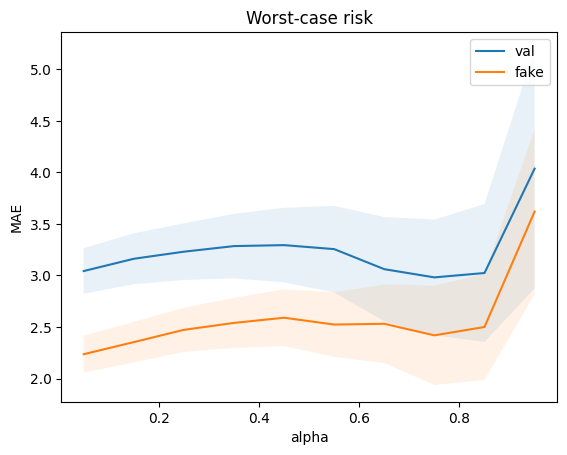

In [455]:
plt.plot(alpha_space, risk_val[:, 0], label='val')
plt.fill_between(alpha_space, risk_val[:, 1], risk_val[:, 2], alpha=0.1)
plt.plot(alpha_space, risk_fake[:, 0], label='fake')
plt.fill_between(alpha_space, risk_fake[:, 1], risk_fake[:, 2], alpha=0.1)
plt.legend(loc='lower left')
plt.title('Worst-case risk')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.legend()
plt.show()